# 1. Import Libraries

In [2]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import pickle
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import gensim
from sklearn.metrics.pairwise import pairwise_distances_argmin
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# 2. Read the Data

In [3]:
dialogues = pd.read_csv("data/dialogues.tsv",sep="\t")

In [4]:
posts = pd.read_csv("data/tagged_posts.tsv",sep="\t")

In [5]:
dialogues.head()

,text,tag
0,Okay -- you're gonna need to learn how to lie.,dialogue
1,I'm kidding. You know how sometimes you just ...,dialogue
2,Like my fear of wearing pastels?,dialogue
3,I figured you'd get to the good stuff eventually.,dialogue
4,Thank God! If I had to hear one more story ab...,dialogue


In [6]:
posts.head()

,post_id,title,tag
0,9,Calculate age in C#,c#
1,16,Filling a DataSet or DataTable from a LINQ que...,c#
2,39,Reliable timer in a console application,c#
3,42,Best way to allow plugins for a PHP application,php
4,59,"How do I get a distinct, ordered list of names...",c#


In [7]:
print("Num Posts:",len(posts))
print("Num Dialogues:",len(dialogues))

Num Posts: 2171575
Num Dialogues: 218609


# 3. Create training data for intent classifier - Chitchat/SO Question

In [8]:
texts  =  list(dialogues[:200000].text.values) + list(posts[:200000].title.values)
labels =  ['dialogue']*200000 + ['stackoverflow']*200000

In [9]:
data = pd.DataFrame({'text':texts,'target':labels})

In [10]:
def text_prepare(text):
    """Performs tokenization and simple preprocessing."""
    
    replace_by_space_re = re.compile('[/(){}\[\]\|@,;]')
    bad_symbols_re = re.compile('[^0-9a-z #+_]')
    stopwords_set = set(stopwords.words('english'))

    text = text.lower()
    text = replace_by_space_re.sub(' ', text)
    text = bad_symbols_re.sub('', text)
    text = ' '.join([x for x in text.split() if x and x not in stopwords_set])

    return text.strip()

In [11]:
# Doing some data cleaning
data['text'] = data['text'].apply(lambda x : text_prepare(x))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data['text'],data['target'],test_size = .1 , random_state=0)

print('Train size = {}, test size = {}'.format(len(X_train), len(X_test)))


Train size = 360000, test size = 40000


# 4. Create Intent classifier

In [13]:
# We will keep our models and vectorizers in this folder

In [14]:
!mkdir resources

mkdir: resources: File exists


In [13]:
def tfidf_features(X_train, X_test, vectorizer_path):
    """Performs TF-IDF transformation and dumps the model."""
    tfv = TfidfVectorizer(dtype=np.float32, min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
    
    X_train = tfv.fit_transform(X_train)
    X_test = tfv.transform(X_test)
    
    pickle.dump(tfv,vectorizer_path)
    return X_train, X_test

In [15]:
X_train_tfidf, X_test_tfidf = tfidf_features(X_train, X_test, open("resources/tfidf.pkl",'wb'))

In [16]:
intent_recognizer = LogisticRegression(C=10,random_state=0)
intent_recognizer.fit(X_train_tfidf,y_train)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
# Check test accuracy.
y_test_pred = intent_recognizer.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy = {}'.format(test_accuracy))

Test accuracy = 0.98985


[[19983   164]
 [  242 19611]]


Text(0.5,257.44,'Predicted label')

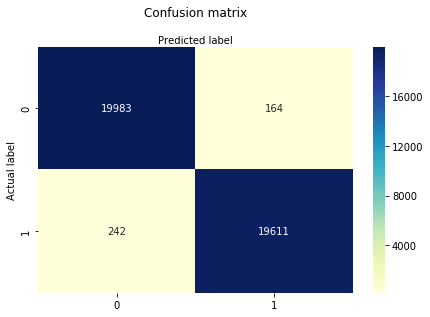

In [18]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_test_pred)
print(confusion_matrix)
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#print(np.sqrt(metrics.mean_absolute_error(y_test, y_test_pred)))

In [19]:
print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))
precision = confusion_matrix[0][0] / (confusion_matrix[0][0]+confusion_matrix[0][1])
print("Precision: "+str(precision))
recall = confusion_matrix[0][0] / (confusion_matrix[0][0]+confusion_matrix[1][0])
print("Recall: "+str(recall))

Accuracy: 0.98985
Precision: 0.9918598302476795
Recall: 0.9880346106304079


In [20]:
pickle.dump(intent_recognizer, open("resources/intent_clf.pkl" , 'wb'))

# 5 Create Programming Language classifier

In [21]:
X = posts['title'].values
y = posts['tag'].values

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('Train size = {}, test size = {}'.format(len(X_train), len(X_test)))

Train size = 1737260, test size = 434315


In [23]:
vectorizer = pickle.load(open("resources/tfidf.pkl", 'rb'))
X_train_tfidf, X_test_tfidf = vectorizer.transform(X_train), vectorizer.transform(X_test)

In [24]:
tag_classifier = OneVsRestClassifier(LogisticRegression(C=5,random_state=0))
tag_classifier.fit(X_train_tfidf,y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [25]:
# Check test accuracy.
y_test_pred = tag_classifier.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('Test accuracy = {}'.format(test_accuracy))

Test accuracy = 0.8043816124241622


[[62623  4793  3723  4146  2466   632    88   110    26   135]
 [ 5287 44830  2485  1686   817   597    77    74   287    22]
 [ 4766  3247 62656  2758  1997   789    76   143    34     7]
 [ 3554  1332  1990 64081  3350   409    55   583    30    32]
 [ 2665  1087  1720  6443 51887   407    54   287    18     9]
 [ 1602  1649  1487  1284   998 34178   285   192     5     4]
 [  209   317   165   276   121   425  5674    24     2     0]
 [  580   374   464  1010   945   229    14 16286     4     1]
 [  260  1933   166   280   139    35     2    13  4218     0]
 [ 3170   187   229   287   226    50    15     7     2  2922]]
             precision    recall  f1-score   support

         c#       0.74      0.80      0.77     78742
      c_cpp       0.75      0.80      0.77     56162
       java       0.83      0.82      0.83     76473
 javascript       0.78      0.85      0.81     75416
        php       0.82      0.80      0.81     64577
     python       0.91      0.82      0.86     416

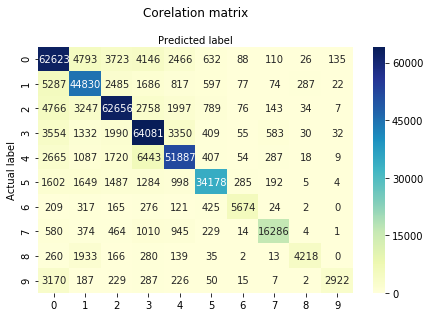

In [26]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_test_pred)
print(confusion_matrix)
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Corelation matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
#print(np.sqrt(metrics.mean_absolute_error(y_test, y_test_pred)))

print(metrics.classification_report(y_test, y_test_pred))

In [26]:
pickle.dump(tag_classifier, open("resources/tag_clf.pkl", 'wb'))

# 6. Store Question database Embeddings

You can use [pre-trained word vectors](https://code.google.com/archive/p/word2vec/) from Google.

In [27]:


# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

We want to convert every question to an embedding and store them. Whenever user asks a stack overflow question we want to use cosine similarity to get the most similar question

In [28]:
def question_to_vec(question, embeddings, dim=300):
    """
        question: a string
        embeddings: dict where the key is a word and a value is its' embedding
        dim: size of the representation

        result: vector representation for the question
    """
    word_tokens = question.split(" ")
    question_len = len(word_tokens)
    question_mat = np.zeros((question_len,dim), dtype = np.float32)
    
    for idx, word in enumerate(word_tokens):
        if word in embeddings:
            question_mat[idx,:] = embeddings[word]
            
    # remove zero-rows which stand for OOV words       
    question_mat = question_mat[~np.all(question_mat == 0, axis = 1)]
    
    # Compute the mean of each word along the sentence
    if question_mat.shape[0] > 0:
        vec = np.array(np.mean(question_mat, axis = 0), dtype = np.float32).reshape((1,dim))
    else:
        vec = np.zeros((1,dim), dtype = np.float32)
        
    return vec

In [29]:
counts_by_tag = posts.groupby(by=['tag'])["tag"].count().reset_index(name = 'count').sort_values(['count'], ascending = False)

In [30]:
counts_by_tag = list(zip(counts_by_tag['tag'],counts_by_tag['count']))
print(counts_by_tag)

[('c#', 394451), ('java', 383456), ('javascript', 375867), ('php', 321752), ('c_cpp', 281300), ('python', 208607), ('ruby', 99930), ('r', 36359), ('vb', 35044), ('swift', 34809)]


In [31]:
! mkdir resources/embeddings_folder

mkdir: resources/embeddings_folder: File exists


In [32]:
for tag, count in counts_by_tag:
    tag_posts = posts[posts['tag'] == tag]
    tag_post_ids = tag_posts['post_id'].values
    tag_vectors = np.zeros((count, 300), dtype=np.float32)
    for i, title in enumerate(tag_posts['title']):
        tag_vectors[i, :] = question_to_vec(title, model, 300)
    # Dump post ids and vectors to a file.
    filename = 'resources/embeddings_folder/'+ tag + '.pkl'
    pickle.dump((tag_post_ids, tag_vectors), open(filename, 'wb'))

# Given a question and tag can I retrieve the most similar question post_id


In [33]:

def get_similar_question(question,tag):
    # get the path where all question embeddings are kept and load the post_ids and post_embeddings
    embeddings_path = 'resources/embeddings_folder/' + tag + ".pkl"
    post_ids, post_embeddings = pickle.load(open(embeddings_path, 'rb'))
    # Get the embeddings for the question
    question_vec = question_to_vec(question, model, 300)
    # find index of most similar post
    best_post_index = pairwise_distances_argmin(question_vec,
                                                post_embeddings)
    # return best post id
    return post_ids[best_post_index]

In [37]:
get_similar_question("how to use list comprehension in python?",'python')

array([5947137])

You can find this question at:
    
https://stackoverflow.com/questions/8278287